<a href="https://colab.research.google.com/github/MANOJ-S-NEGI/TensorFlow_NLP/blob/main/Project_SKIM_LIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
! nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-2c5616c5-d8d5-b914-136f-1dd8f6fe8f95)


In [172]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [173]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [174]:
## importing functions:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import zipfile
import random

In [175]:
## check int the file in directory:

filename=[data_dir+filename for filename in os.listdir(data_dir)]
filename

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [176]:
## creating a function to read the line of document: Checking

def get_lines(filename):
    with open(filename,'r')as file:
        return file.readlines()

##readin the trained line:
train_lines=get_lines(filename[2])
train_lines[:4]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n']

In [177]:
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """      

'Returns a list of dictionaries of abstract line data.\n\nTakes in filename, reads its contents and sorts through each line,\nextracting things like the target label, the text of the sentence,\nhow many sentences are in the current abstract and what sentence number\nthe target line is.\n\nArgs:\n    filename: a string of the target text file to read and extract line data\n    from.\n\nReturns:\n    A list of dictionaries each containing a line from an abstract,\n    the lines label, the lines position in the abstract and the total number\n    of lines in the abstract where the line is from. For example:\n\n    [{"target": \'CONCLUSION\',\n      "text": The study couldn\'t have gone better, turns out people are kinder than you think",\n      "line_number": 8,\n      "total_lines": 8}]\n'

In [178]:
def process_text(filename):
    input_line=get_lines(filename)
    abstract_line=""
    abstract_sample=[]

    for line in input_line:       #Check/go through the lines one by one
        if line.startswith('###'): #if line start with '###'then
            number_id=line        #print the line and store it in number id variable
            abstract_line=""     # and make abstract line -reset
        elif line.isspace():      #if not ### in line but space is there then
            abstract_line_split=abstract_line.splitlines()#split the line from the space to....
            # Iterate through each line in abstract and count them at the same time:
            for id_number,abstract_line in enumerate(abstract_line_split): #enumerate over                
                target_text_split=abstract_line.split('\t')                 #split it again from text '\t'
                line_data={}                                                # create empty dict to store data from line

                line_data['Target']=target_text_split[0]                    #put target as label and store all index 0 item in it
                line_data['Text']=target_text_split[1].lower()              #put Text as label and store all index 1 item in it
                line_data['Line_number']=id_number
                line_data['Total_lines']=len(abstract_line_split)-1           # as index is starting from the zero
                abstract_sample.append(line_data)                           # adding to abstract sample 
        else:# if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_line += line

    return abstract_sample

In [179]:
%%time
train_samples= process_text(data_dir + "train.txt")
val_samples = process_text(data_dir + "dev.txt") # dev is another name for validation set
test_samples = process_text(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)


CPU times: user 580 ms, sys: 130 ms, total: 710 ms
Wall time: 716 ms


In [180]:
train_samples[:14]

[{'Line_number': 0,
  'Target': 'OBJECTIVE',
  'Text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'Total_lines': 11},
 {'Line_number': 1,
  'Target': 'METHODS',
  'Text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'Total_lines': 11},
 {'Line_number': 2,
  'Target': 'METHODS',
  'Text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'Total_lines': 11},
 {'Line_number': 3,
  'Target': 'METHODS',
  'Text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'Total_lines': 11},
 {'Line_number': 4,
  'Target': 'METHODS',
  'Text': 'secondary outcome measures include

In [181]:
## putting every thing in dtaframe:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(24)

,Target,Text,Line_number,Total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [182]:
pd.DataFrame(train_df.Target.value_counts())

,Target
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


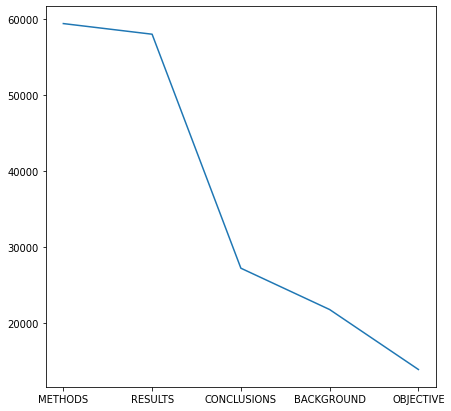

In [183]:
plt.figure(figsize=(7,7))
plt.plot(train_df.Target.value_counts());

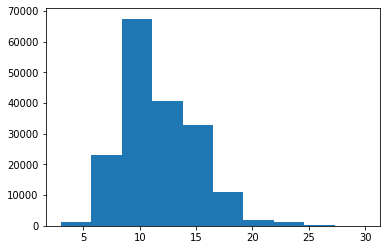

In [184]:
plt.hist(train_df.Total_lines);

### Changing target into numerical values:
---
1.   Convert into Hot_Encoder
2.   Convert into label_Encoder



In [185]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["Target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["Target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["Target"].to_numpy().reshape(-1, 1))

# Check what training labels look like:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [186]:
train_labels_one_hot.shape

(180040, 5)

In [187]:
# converting the hotencoder into label

from sklearn.preprocessing import LabelEncoder
LabelEncoder=LabelEncoder()
train_label_encoder= LabelEncoder.fit_transform(train_df['Target'].to_numpy())
valid_label_encoder= LabelEncoder.fit_transform(val_df['Target'].to_numpy())
test_label_encoder= LabelEncoder.fit_transform(test_df['Target'].to_numpy())

train_label_encoder

array([3, 2, 2, ..., 4, 1, 1])

In [188]:
# Convert abstract text lines into lists 
train_sentences = train_df["Text"].tolist()
val_sentences = val_df["Text"].tolist()
test_sentences = test_df["Text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [189]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(LabelEncoder.classes_)
class_names = LabelEncoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

###creating
the model_0:the Base model Naive Bayes

---





In [20]:
## lets create the model_0:the Base model Naive Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0= Pipeline([("tf-idf", TfidfVectorizer()), ("clf", MultinomialNB())])

## fitting the model:
model_0.fit(train_sentences,train_label_encoder)

## model score
model_0.score(train_sentences,train_label_encoder)

0.7516829593423684

In [21]:
# checking the base_line prediction:
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [23]:
# Calculate baseline results
baseline_results = calculate_results(y_true=valid_label_encoder,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

average words:26.338269273494777


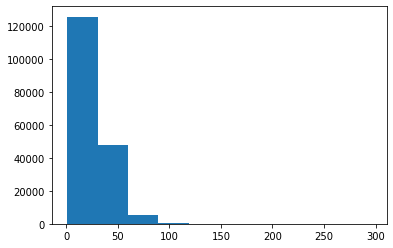

In [24]:
## getting the average sentence:
## split the train_sentences in word by word spaces:
sentence_length=[len(sentence.split())for sentence in train_sentences]

## pick the mean :
sent_mean=np.mean(sentence_length)
print(f'average words:{sent_mean}')
plt.hist(sentence_length);


```
we can take word sequence between 60 to 80
```
### creating the model_1

In [25]:
## text Vectorization:
text_vectorization=tf.keras.layers.TextVectorization(max_tokens=68000,      # given in published paper
                                  output_sequence_length=75)

text_vectorization.adapt(train_sentences)                                   ##adapting the text vactorization:


###Create custom text embedding
---
Our token_vectorization layer maps the words in our text directly to numbers.


However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an embedding.

In [222]:
text_vocab=text_vectorization.get_vocabulary()
print(f"len of text_vocab:{len(text_vocab)}")
print(f"Most common words in the vocabulary: {text_vocab[:5]}")
print(f"Least common words in the vocabulary: {text_vocab[-5:]}\\nget_config():\n")
text_vectorization.get_config()

len of text_vocab:64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']\nget_config():



{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 75,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [27]:
token_embed=tf.keras.layers.Embedding(input_dim=len(text_vocab),
                                      output_dim=128, # emmbeding size(integer. Dimension of the dense embedding.)
                                      mask_zero=True)## If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary(input_dim of vocabulary =+ 1)
                                   

### checking the text vectorizaton and text embedding:


In [28]:
## example testing the text vectoriztion:
train_sentence_testing=random.choice(train_sentences)
print(f'random_text:{train_sentence_testing}\n number of words in srandom text :{len(train_sentence_testing.split())}')

text_test=text_vectorization([train_sentence_testing])
print(f'random sentence after the vectorization will be like: \n{text_test}')


# Show example embedding

embedded_sentence = token_embed(text_test)
print(f"\nSentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")


random_text:bone graft substitutes are widely used for reconstruction of posttraumatic bone defects .
 number of words in srandom text :13
random sentence after the vectorization will be like: 
[[  410  1031 15391    58  1580    98    11  1314     4  3052   410  3318
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]]

Sentence after embedding:
[[[-0.00655812  0.03030772 -0.00195529 ... -0.03159471 -0.00807601
    0.00501764]
  [ 0.04703236  0.00779776 -0.0216302  ... -0.03664806  0.01383643
   -0.01835771]
  [ 0.0107311  -0.04402743  0.01090587 ... -0.00117099 -0.03140034
    0.04872116]
  ...
  [ 0.02843093 -0.00264515 -0.00780158 ... -0.02336605 -0.

The[ tf.data.Dataset] API supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:
---
* Create a source dataset from your input data.
* Apply dataset transformations to preprocess the data.
* Iterate over the dataset and process the elements.


Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

In [29]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset


<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### Model 1: Conv1D with token embeddings

---
```

Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

We're also going to be following the standard machine learning workflow of:

Build model
Train model
Evaluate model (make predictions and compare to ground truth)
```

In [30]:
# setting the layers of model:

input=tf.keras.layers.Input(shape=(1,),dtype='string')
x=text_vectorization(input)
x=token_embed(x)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x=tf.keras.layers.GlobalMaxPooling1D()(x)
output=tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model_1=tf.keras.Model(input,output)

##compiling the model:
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam())

# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 75)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 75, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 75, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [31]:
#fitting the model:
model_1_history=model_1.fit(train_dataset,
                            epochs=5,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                             validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)) # only validate on 25% of batches                    
)

Epoch 1/5
562/562 [==============================] - 19s 15ms/step - loss: 0.3077 - accuracy: 0.6634 - val_loss: 0.2241 - val_accuracy: 0.7696
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.2157 - accuracy: 0.7848 - val_loss: 0.2049 - val_accuracy: 0.7989
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.2043 - accuracy: 0.7950 - val_loss: 0.1961 - val_accuracy: 0.8122
Epoch 4/5
562/562 [==============================] - 8s 14ms/step - loss: 0.1973 - accuracy: 0.8067 - val_loss: 0.1934 - val_accuracy: 0.8102
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 0.1959 - accuracy: 0.8076 - val_loss: 0.1876 - val_accuracy: 0.8195


In [32]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.1859 - accuracy: 0.8186


[0.1859089881181717, 0.8185819983482361]

In [33]:
model_1_preds_probs=model_1.predict(valid_dataset)
model_1_preds_probs

array([[7.34406292e-01, 1.66001126e-01, 9.08044516e-04, 9.05864313e-02,
        8.09819996e-03],
       [2.89302766e-01, 6.56454206e-01, 6.79573917e-04, 3.87576520e-02,
        1.48057584e-02],
       [6.12614602e-02, 9.46383364e-03, 7.27165584e-03, 9.21653211e-01,
        3.49917158e-04],
       ...,
       [1.07746935e-04, 2.72719117e-05, 5.12437779e-04, 7.06298961e-05,
        9.99281943e-01],
       [3.54348659e-03, 5.32742023e-01, 2.54241414e-02, 5.44385472e-03,
        4.32846516e-01],
       [7.50379870e-03, 9.90355611e-01, 1.40464096e-03, 2.17633045e-04,
        5.18432818e-04]], dtype=float32)

In [34]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_preds_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [35]:
model_1_results=calculate_results(valid_label_encoder,model_1_preds)
model_1_results

{'accuracy': 81.85820203892493,
 'f1': 0.8151241956828176,
 'precision': 0.8181912260821139,
 'recall': 0.8185820203892493}

#### Model 2: Feature extraction with pretrained token embeddings(TRANSFER LEARNING)

In [36]:
# Download pretrained TensorFlow Hub USE
hub_embed =hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")
hub_embed

In [37]:
## checking the embeding:
check_embed_sent= random.choice(train_sentences)
print(f"random sentence before embeding the sentence encoder:\n{check_embed_sent}\n")
embed_sentence=hub_embed([check_embed_sent])
print(f"embeding the sentence encoder:\n{embed_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(embed_sentence[0])}")

random sentence before embeding the sentence encoder:
treatment decisions for individual patients may be guided by the different side effect profiles of the two drugs and patient preference .

embeding the sentence encoder:
[-0.04343864 -0.06744736 -0.02284578  0.07365428  0.0042408  -0.04221601
  0.01995149  0.00101102 -0.07449496 -0.00401499  0.08942671 -0.0486832
  0.01522031  0.04455499  0.01632995 -0.0160047  -0.08985067 -0.03138693
 -0.07204355  0.06100776  0.07850106  0.06643213 -0.01473225 -0.07562634
  0.06215611 -0.01427895  0.02529307  0.04825346  0.02638502  0.0479467 ] (truncated output)...

Length of sentence embedding:
512


In [38]:
## Building and fitting an NLP feature extraction model from TensorFlow Hub

input=tf.keras.layers.Input(shape=[],dtype=tf.string)
embed=hub_embed(input)
layer_x=tf.keras.layers.Dense(128,activation='relu')(embed)
output=tf.keras.layers.Dense(num_classes,activation='sigmoid')(layer_x)
model_2=tf.keras.Model(input,output)
# compiling the model:

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [39]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [40]:
## fitting the models:

history_model_2=model_2.fit(train_dataset,
                            epochs=5,
                            steps_per_epoch=int(0.25*len(train_dataset)),
                            validation_data=valid_dataset,
                            validation_steps= int(0.25*len(valid_dataset)))

Epoch 1/5
1406/1406 [==============================] - 32s 21ms/step - loss: 0.2991 - accuracy: 0.6704 - val_loss: 0.2634 - val_accuracy: 0.7111
Epoch 2/5
1406/1406 [==============================] - 29s 21ms/step - loss: 0.2565 - accuracy: 0.7170 - val_loss: 0.2485 - val_accuracy: 0.7328
Epoch 3/5
1406/1406 [==============================] - 29s 20ms/step - loss: 0.2462 - accuracy: 0.7322 - val_loss: 0.2394 - val_accuracy: 0.7427
Epoch 4/5
1406/1406 [==============================] - 28s 20ms/step - loss: 0.2379 - accuracy: 0.7430 - val_loss: 0.2357 - val_accuracy: 0.7480
Epoch 5/5
   1/1406 [..............................] - ETA: 28s - loss: 0.2717 - accuracy: 0.8125WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 7030 batches). You may need to use the repeat() function when building your dataset.


1406/1406 [==============================] - 4s 3ms/step - loss: 0.2733 - accuracy: 0.7361 - val_loss: 0.2357 - val_accuracy: 0.7471


In [41]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.2339 - accuracy: 0.7472


[0.23389221727848053, 0.7472196221351624]

In [42]:
## predicting the possible probabilities:
model_2_pred_prob=model_2.predict(valid_dataset)
model_2_pred= np.argmax(model_2_pred_prob,axis=1)
model_2_pred

array([1, 1, 0, ..., 4, 4, 1])

In [43]:
print(model_2_pred[:10])
print(class_names[model_2_pred][:10])

[1 1 0 2 2 4 2 2 4 1]
['CONCLUSIONS' 'CONCLUSIONS' 'BACKGROUND' 'METHODS' 'METHODS' 'RESULTS'
 'METHODS' 'METHODS' 'RESULTS' 'CONCLUSIONS']


In [44]:
model_2_results=calculate_results(valid_label_encoder,model_2_pred)
model_2_results

{'accuracy': 74.72196478220575,
 'f1': 0.7418694971196027,
 'precision': 0.7413903061193104,
 'recall': 0.7472196478220574}

### Model 3: Conv1D with character embeddings

In [45]:
# Make function to split sentences into characters
def split_char(text):
    return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_char(train_sentences[1])

'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .'

In [46]:
# spliting all train valid and test:
train_chars=[split_char(train)for train in train_sentences]
val_chars=[split_char(valid) for valid in val_sentences]
test_chars=[split_char(test) for test in test_sentences]

train_chars[2]


'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a n d   s y s t e m i c   i n f l a m m a t i o n   m a r k e r s   .'

149.3662574983337


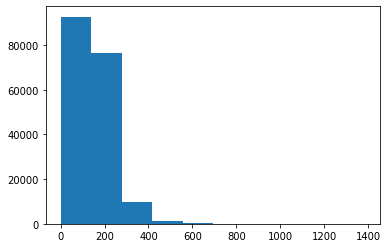

In [47]:
## finding the average character length:

char_len=[len(sentence)for sentence in train_sentences]
mean_char=np.mean(char_len)
print(mean_char)

plt.hist(char_len);

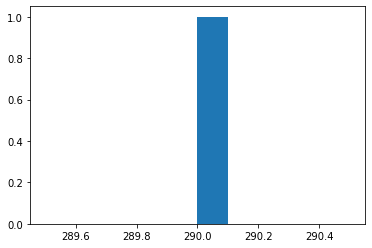

In [48]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_len, 95))
plt.hist(output_seq_char_len);

In [49]:
## calling the keyboard token:
import string
alphabet=string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### creating the char vectorizor and embedding layer.

In [50]:
## creating the token vectorizer :
NUM_CHAR_TOKENS=len(alphabet)+2
char_vectorizor= tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                   output_sequence_length=output_seq_char_len,
                                                   standardize=None)
char_vectorizor.adapt(train_chars)

## Creatimg the embedding the layer:
char_embed= tf.keras.layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                                   output_dim=25,            # (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                                     mask_zero=False)        # don't use masks (this messes up model_5 if set to True

In [54]:
## checking character vectorizor layer:
random_sentence=random.choice(train_chars)
print(f"random sentence is :{random_sentence}\n")
print(f'Char vectorizor layer :{char_vectorizor([random_sentence])}\n')


random sentence is :g e n e   e x p r e s s i o n   p r o f i l i n g   t e s t   s c o r e s   h a v e   p r i m a r i l y   b e e n   u s e d   t o   i d e n t i f y   h e a r t   t r a n s p l a n t   r e c i p i e n t s   w h o   h a v e   a   l o w   p r o b a b i l i t y   o f   r e j e c t i o n   a t   t h e   t i m e   o f   s u r v e i l l a n c e   t e s t i n g   .

Char vectorizor layer :[[18  2  6  2  2 30 14  8  2  9  9  4  7  6 14  8  7 17  4 12  4  6 18  3
   2  9  3  9 11  7  8  2  9 13  5 22  2 14  8  4 15  5  8  4 12 20 23  2
   2  6 16  9  2 10  3  7  4 10  2  6  3  4 17 20 13  2  5  8  3  3  8  5
   6  9 14 12  5  6  3  8  2 11  4 14  4  2  6  3  9 21 13  7 13  5 22  2
   5 12  7 21 14  8  7 23  5 23  4 12  4  3 20  7 17  8  2 37  2 11  3  4
   7  6  5  3  3 13  2  3  4 15  2  7 17  9 16  8 22  2  4 12 12  5  6 11
   2  3  2  9  3  4  6 18 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0

In [55]:
# Testing character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_sentence}\n")
char_embed_example = char_embed(char_vectorizor([random_sentence]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
g e n e   e x p r e s s i o n   p r o f i l i n g   t e s t   s c o r e s   h a v e   p r i m a r i l y   b e e n   u s e d   t o   i d e n t i f y   h e a r t   t r a n s p l a n t   r e c i p i e n t s   w h o   h a v e   a   l o w   p r o b a b i l i t y   o f   r e j e c t i o n   a t   t h e   t i m e   o f   s u r v e i l l a n c e   t e s t i n g   .

Embedded chars (after vectorization and embedding):
[[[-0.01059945  0.03848007 -0.01301588 ... -0.03743071 -0.0498977
   -0.01204125]
  [ 0.03954727  0.00903891 -0.02554734 ... -0.03634654 -0.03170717
    0.02436967]
  [ 0.04058724  0.03648393  0.00266258 ...  0.02397852  0.04239846
    0.01311816]
  ...
  [-0.0388683   0.0485981  -0.03232867 ...  0.04622832 -0.00523452
   -0.04570807]
  [-0.0388683   0.0485981  -0.03232867 ...  0.04622832 -0.00523452
   -0.04570807]
  [-0.0388683   0.0485981  -0.03232867 ...  0.04622832 -0.00523452
   -0.04570807]]]

Character embedding shape: (

In [56]:
## creating the model_3:
input=tf.keras.layers.Input(shape=(1,),dtype='string')
x=char_vectorizor(input)
x=char_embed(x)
x=tf.keras.layers.Dense(128,activation='relu')(x)
x=tf.keras.layers.GlobalMaxPooling1D()(x)
output=tf.keras.layers.Dense(num_classes,activation='sigmoid')(x)
model_3=tf.keras.Model(input,output)

## compiling the model_3
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_3.summary()## getting the summary

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 290, 25)           1750      
                                                                 
 dense_3 (Dense)             (None, 290, 128)          3328      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 5)                 645 

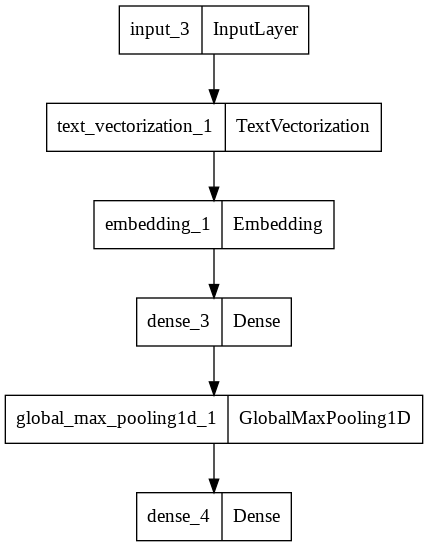

In [57]:
# Plot hybrid token and character model
from tensorflow.keras.utils  import plot_model
plot_model(model_3)

In [58]:
## converting into dataset for enhaced performance:
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [59]:
## Fitting the mokdel:
model_3_history= model_3.fit(train_char_dataset,
                             validation_data=valid_char_dataset,
                             validation_steps=int(0.25*len(valid_char_dataset)),
                             steps_per_epoch=int(0.25*len(train_char_dataset)),
                             epochs=5)

Epoch 1/5
1406/1406 [==============================] - 16s 11ms/step - loss: 0.4094 - accuracy: 0.4737 - val_loss: 0.3863 - val_accuracy: 0.5197
Epoch 2/5
1406/1406 [==============================] - 21s 15ms/step - loss: 0.3858 - accuracy: 0.5137 - val_loss: 0.3825 - val_accuracy: 0.5281
Epoch 3/5
1406/1406 [==============================] - 22s 16ms/step - loss: 0.3815 - accuracy: 0.5183 - val_loss: 0.3780 - val_accuracy: 0.5297
Epoch 4/5
1406/1406 [==============================] - 15s 11ms/step - loss: 0.3824 - accuracy: 0.5214 - val_loss: 0.3768 - val_accuracy: 0.5351
Epoch 5/5
   1/1406 [..............................] - ETA: 18s - loss: 0.3738 - accuracy: 0.5312WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 7030 batches). You may need to use the repeat() function when building your dataset.


1406/1406 [==============================] - 1s 752us/step - loss: 0.3853 - accuracy: 0.4583 - val_loss: 0.3772 - val_accuracy: 0.5347


In [60]:
# Evaluate on whole validation dataset
model_3.evaluate(valid_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.3761 - accuracy: 0.5337


[0.376143217086792, 0.5336952209472656]

In [61]:
## predicting the possible probabilities:
model_3_pred_prob=model_3.predict(valid_char_dataset)
model_3_pred= np.argmax(model_3_pred_prob,axis=1)
model_3_pred

array([2, 4, 2, ..., 4, 4, 2])

In [62]:
print(model_3_pred[:10])
print(class_names[model_3_pred][:10])

[2 4 2 2 2 2 2 2 4 2]
['METHODS' 'RESULTS' 'METHODS' 'METHODS' 'METHODS' 'METHODS' 'METHODS'
 'METHODS' 'RESULTS' 'METHODS']


In [63]:
model_3_results=calculate_results(valid_label_encoder,model_3_pred)
model_3_results

{'accuracy': 53.369522044220844,
 'f1': 0.5186759283062559,
 'precision': 0.5426506523506364,
 'recall': 0.5336952204422084}

####Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)


This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

* Create a token-level model (similar to model_1)
* Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
* Combine (using layers.Concatenate) the outputs of 1 and 2
* Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
* Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [64]:
# 1. Setup token inputs/model-2  (layer)
token_input=tf.keras.layers.Input(shape=[],dtype=tf.string)
x=hub_embed(token_input)
token_output=tf.keras.layers.Dense(num_classes,activation='relu')(x)
token_model=tf.keras.Model(token_input,token_output)


# 2. Setup char inputs/model-3  (layer_2)
char_input=tf.keras.layers.Input(shape=(1,),dtype='string')
x=char_vectorizor(char_input)
x=char_embed(x)
x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(x)
char_output=tf.keras.layers.Dense(128,activation='relu')(x)
char_model = tf.keras.Model(inputs=char_input,outputs=char_output)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat=tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,char_model.output])


**tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, **kwargs)**

#### Applies Dropout to the input.

---

The Dropout layer randomly sets input units to 0 with a frequency of rate at 

* each step during training time, which helps prevent overfitting.
* Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

**Note :** that the Dropout layer only applies when training is set to **True** such that no values are dropped during inference.

When using **model.fit**, training will be appropriately set to True automatically, and in other contexts, you can set the kwarg explicitly to True when calling the layer.

(This is in contrast to setting **trainable=False** for a Dropout layer. trainable does not affect the layer's behavior, as Dropout does not have any variables/weights that can be frozen during training.)


In [65]:
# 4. Create output layers - addition of dropout discussed in 4.2 of [https://arxiv.org/pdf/1612.05251.pdf]
combined_dropout=tf.keras.layers.Dropout(0.5)(token_char_concat)                          # dropout rate is 0.5 taken (layer 4)
combined_dense =tf.keras.layers.Dense(200, activation='relu')(combined_dropout)          # (layer 5)
final_dropout =tf.keras.layers.Dropout(0.5)(combined_dense)                              # (layer 6) 
output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(final_dropout)   # (layer 7)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [66]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['input_5[0][0]']                
 orization)                                                                                       
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 290, 25)      1750        [

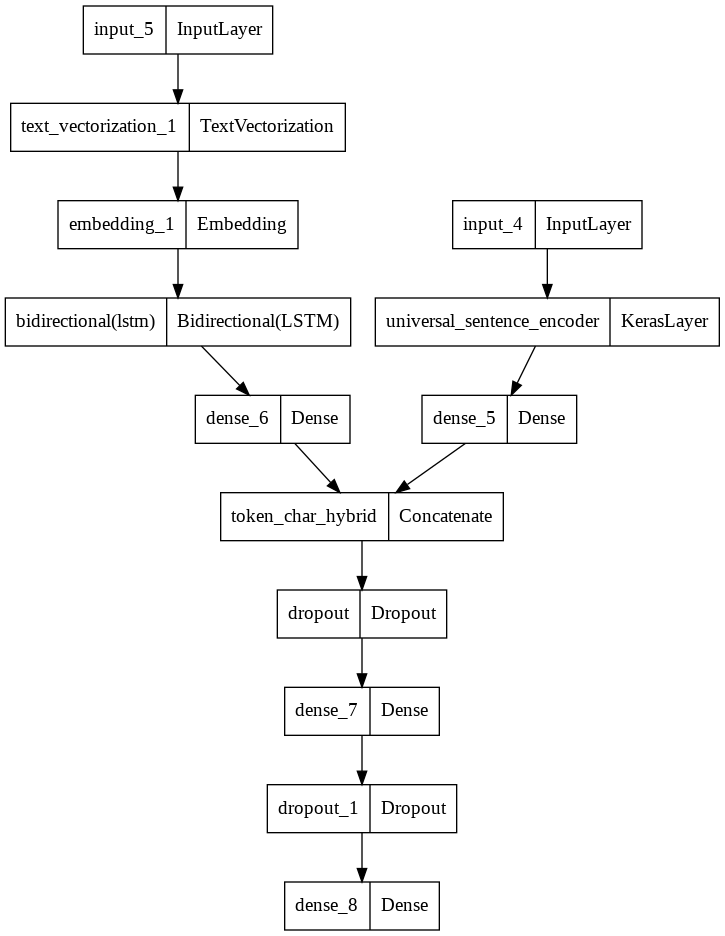

In [67]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4,)

In [68]:
# Compile token char model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [69]:
## efficient processing pipeline:
train_token_char_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_token_char_label=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset=tf.data.Dataset.zip((train_token_char_data,train_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

valid_token_char_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
valid_token_char_label=tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
valid_token_char_dataset=tf.data.Dataset.zip((valid_token_char_data,valid_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [70]:
#fitting the model:
history_model_4=model_4.fit(train_token_char_dataset,
                            validation_data=valid_token_char_dataset,
                            epochs=5,
                            steps_per_epoch=int(0.25*len(train_token_char_dataset)),
                            validation_steps=int(0.25*len(valid_token_char_dataset)))

Epoch 1/5
1406/1406 [==============================] - 170s 117ms/step - loss: 0.3812 - accuracy: 0.5156 - val_loss: 0.3043 - val_accuracy: 0.6506
Epoch 2/5
1406/1406 [==============================] - 162s 116ms/step - loss: 0.3341 - accuracy: 0.5906 - val_loss: 0.2878 - val_accuracy: 0.6680
Epoch 3/5
1406/1406 [==============================] - 163s 116ms/step - loss: 0.3154 - accuracy: 0.6222 - val_loss: 0.2805 - val_accuracy: 0.6813
Epoch 4/5
1406/1406 [==============================] - 163s 116ms/step - loss: 0.3067 - accuracy: 0.6364 - val_loss: 0.2728 - val_accuracy: 0.7018
Epoch 5/5
   3/1406 [..............................] - ETA: 2:27 - loss: 0.3356 - accuracy: 0.5694WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 7030 batches). You may need to use the repeat() function when building your dataset.


1406/1406 [==============================] - 11s 8ms/step - loss: 0.3356 - accuracy: 0.5694 - val_loss: 0.2718 - val_accuracy: 0.7001


In [71]:
# Evaluate on the whole validation dataset
model_4.evaluate(valid_token_char_dataset)

945/945 [==============================] - 49s 52ms/step - loss: 0.2703 - accuracy: 0.7036


[0.27028149366378784, 0.7035946249961853]

In [72]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(valid_token_char_dataset)
model_4_pred_probs

array([[3.3109811e-01, 4.4701093e-01, 7.6033391e-02, 6.8036251e-02,
        7.7821247e-02],
       [3.2896781e-01, 4.1387025e-01, 9.7066641e-02, 8.0101065e-02,
        7.9994261e-02],
       [5.5208313e-01, 1.0687615e-01, 4.3177128e-02, 2.8034139e-01,
        1.7522139e-02],
       ...,
       [4.3359385e-05, 1.2711872e-03, 6.0267765e-03, 2.8440156e-06,
        9.9265587e-01],
       [8.5740453e-03, 5.2658219e-02, 3.0951637e-01, 2.6598375e-03,
        6.2659156e-01],
       [1.1491960e-01, 6.5961444e-01, 6.2671974e-02, 3.2662448e-02,
        1.3013154e-01]], dtype=float32)

In [73]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 0, ..., 4, 4, 1])>

In [74]:
model_4_results=calculate_results(valid_label_encoder,model_4_preds)
model_4_results

{'accuracy': 70.35945981729115,
 'f1': 0.6929930741735105,
 'precision': 0.6963587059625882,
 'recall': 0.7035945981729115}

In [75]:
class_names[model_4_preds][:10]

array(['CONCLUSIONS', 'CONCLUSIONS', 'BACKGROUND', 'METHODS', 'METHODS',
       'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'METHODS'],
      dtype=object)

###Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings


It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called **feature engineering.**

Can you think of something important about the sequences we're trying to classify?

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled CONCLUSIONS at the beggining and sequences labelled OBJECTIVE at the end?

Abstracts typically come in a sequential order, such as:




* OBJECTIVE ...
* METHODS ...
* METHODS ...
* METHODS ...
* RESULTS ...
* CONCLUSIONS ...


> or



* BACKGROUND ...
* OBJECTIVE ...
* METHODS ...
* METHODS ...
* RESULTS ...
* RESULTS ...
* CONCLUSIONS ...
* CONCLUSIONS ...
>Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,

* Sentence 1 of 10 ...
* Sentence 2 of 10 ...
* Sentence 3 of 10 ...
* Sentence 4 of 10 ...
...
>You might've noticed this when we created our preprocess_text_with_line_numbers() function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the "line_number" and "total_lines" columns of our DataFrames.

In [76]:
## inspeting the dataframe (created above)
train_df[:15]

,Target,Text,Line_number,Total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11



The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

In [77]:
# How many different line numbers are there?
train_df["Line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: Line_number, dtype: int64

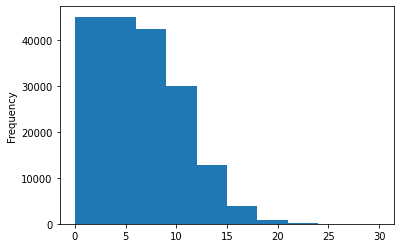

In [78]:
train_df.Line_number.plot.hist();

In [79]:
# How many different total lines are there?
train_df["Total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: Total_lines, dtype: int64

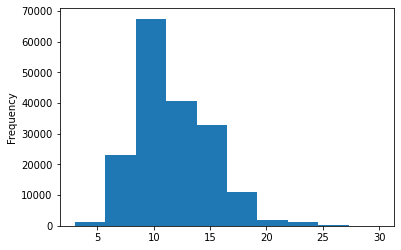

In [80]:
train_df.Total_lines.plot.hist();

In [81]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["Line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["Line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["Line_number"].to_numpy(), depth=15)

In [82]:
# using tensorflow create one hot encoded tensor of "Total_line" column
train_total_line_one_hot=tf.one_hot(train_df['Total_lines'].to_numpy(),depth=20)
val_total_line_one_hot=tf.one_hot(val_df['Total_lines'].to_numpy(),depth=20)
test_total_line_one_hot=tf.one_hot(test_df['Total_lines'].to_numpy(),depth=20)

In [83]:
train_total_line_one_hot.shape,train_line_numbers_one_hot.shape

(TensorShape([180040, 20]), TensorShape([180040, 15]))

In [84]:
train_total_line_one_hot.dtype,train_line_numbers_one_hot.dtype

(tf.float32, tf.float32)

>Building a tribrid embedding model


>It's time to build the biggest model we've built yet. One which incorporates token embeddings, character embeddings and our newly crafted positional embeddings.


> we're going to go through the following steps:

* Create a token-level model (similar to model_1)
*  Create a character-level model (similar to model_3 with a slight 
*  modification to reflect the paper)
* Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
* Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
* Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical 
Paper Abstracts
* Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
* Create an output layer to accept the tribrid embedding and output predicted label probabilities
* Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model





In [85]:
# 1. Setup token inputs/model-2  (layer)
token_input=tf.keras.layers.Input(shape=[],dtype=tf.string)
x=hub_embed(token_input)
token_output=tf.keras.layers.Dense(num_classes,activation='relu')(x)
token_model=tf.keras.Model(token_input,token_output)


# 2. Setup char inputs/model-3  (layer_2)
char_input=tf.keras.layers.Input(shape=(1,),dtype='string')
x=char_vectorizor(char_input)
x=char_embed(x)
x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(x)
char_output=tf.keras.layers.Dense(128,activation='relu')(x)
char_model = tf.keras.Model(inputs=char_input,outputs=char_output)

# 3. Line numbers inputs
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x =  tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs =  tf.keras.layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
x =  tf.keras.layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=x)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings =  tf.keras.layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z =  tf.keras.layers.Dense(256, activation="relu")(combined_embeddings)
z =  tf.keras.layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z =  tf.keras.layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                          total_line_model.output,z])

# 7. Create output layer
output_layer = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [86]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['input_7[0][0]']                
 orization)                                                                                       
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 290, 25)      1750        ['text_vectorization_1[2][0

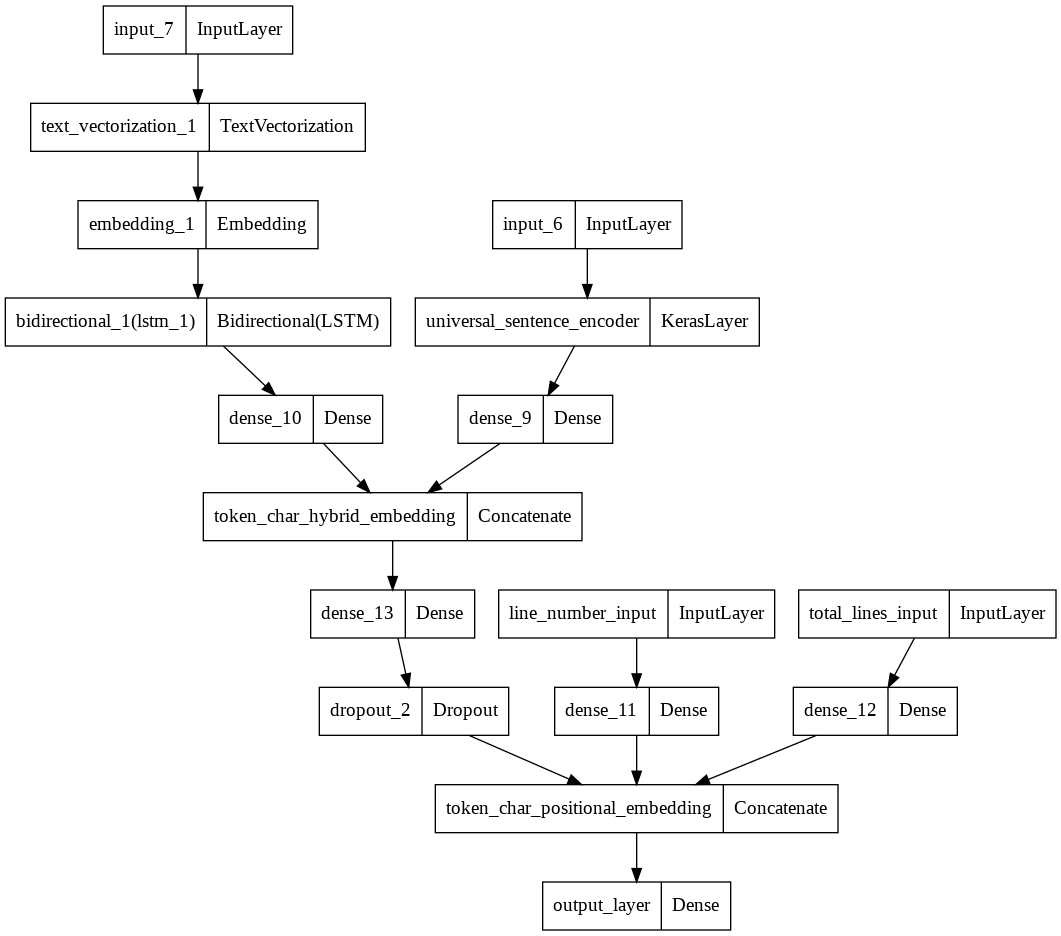

In [87]:
plot_model(model_5)

In [88]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fcc595d9390> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fcc60096d90> True
<keras.engine.input_layer.InputLayer object at 0x7fccd370d550> True
<keras.layers.embeddings.Embedding object at 0x7fcc5bfb9a90> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fccd7a6f550> False
<keras.layers.wrappers.Bidirectional object at 0x7fccd36bb910> True
<keras.layers.core.dense.Dense object at 0x7fccd370d210> True
<keras.layers.core.dense.Dense object at 0x7fccd37d2ed0> True
<keras.layers.merge.Concatenate object at 0x7fccd37b48d0> True
<keras.engine.input_layer.InputLayer object at 0x7fccd3aad190> True
<keras.engine.input_layer.InputLayer object at 0x7fccd3793d50> True
<keras.layers.core.dense.Dense object at 0x7fccd379fe10> True
<keras.layers.core.dense.Dense object at 0x7fccd37b6fd0> True
<keras.layers.core.dense.Dense object at 0x7fccd37b6a10> True
<keras.layers.core.dropout.Dropout object at 0x7fccd37

In [89]:
model_5.layers[4]# can release all the layer to enhance the result 

In [90]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [91]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_line_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_line_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [92]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 71s 119ms/step - loss: 1.1578 - accuracy: 0.6788 - val_loss: 1.0065 - val_accuracy: 0.7846
Epoch 2/5
562/562 [==============================] - 65s 115ms/step - loss: 0.9879 - accuracy: 0.8010 - val_loss: 0.9696 - val_accuracy: 0.8082
Epoch 3/5
562/562 [==============================] - 66s 117ms/step - loss: 0.9695 - accuracy: 0.8105 - val_loss: 0.9620 - val_accuracy: 0.8108
Epoch 4/5
562/562 [==============================] - 65s 115ms/step - loss: 0.9577 - accuracy: 0.8237 - val_loss: 0.9484 - val_accuracy: 0.8201
Epoch 5/5
562/562 [==============================] - 65s 116ms/step - loss: 0.9588 - accuracy: 0.8203 - val_loss: 0.9478 - val_accuracy: 0.8251


In [93]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 52s 53ms/step


array([[0.5291566 , 0.08097065, 0.02019414, 0.33616766, 0.03351091],
       [0.5713879 , 0.07868951, 0.09573833, 0.23603408, 0.01815017],
       [0.3576879 , 0.14015625, 0.1422568 , 0.28890386, 0.07099523],
       ...,
       [0.04818918, 0.08256998, 0.0462731 , 0.03009084, 0.79287696],
       [0.02555041, 0.25199088, 0.11009289, 0.02302312, 0.58934265],
       [0.07299177, 0.63231355, 0.17057547, 0.028688  , 0.09543122]],
      dtype=float32)

In [94]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [95]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=valid_label_encoder,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.5963193433073,
 'f1': 0.8215989967655076,
 'precision': 0.8294250659009298,
 'recall': 0.825963193433073}

Model 6: Transfer Learning with pretrained convid embedding + character embeddings + positional embeddings

In [96]:
# 1. Setup token inputs/model-2  (layer)
convd_input=tf.keras.layers.Input(shape=[],dtype=tf.string,name="convd_input")
x=text_vectorization(convd_input)
x=token_embed(x)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x=tf.keras.layers.GlobalMaxPooling1D()(x)
convd_output=tf.keras.layers.Dense(num_classes,activation='relu')(x)
convd_model=tf.keras.Model(convd_input,convd_output)

# 2. Setup char inputs/model-3  (layer_2)
char_input=tf.keras.layers.Input(shape=(1,),dtype='string',name='char_input')
x=char_vectorizor(char_input)
x=char_embed(x)
x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(x)
char_output=tf.keras.layers.Dense(128,activation='relu')(x)
char_model = tf.keras.Model(inputs=char_input,outputs=char_output)

# 3. Line numbers inputs
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x =  tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs =  tf.keras.layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
x =  tf.keras.layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=x)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings =  tf.keras.layers.Concatenate(name="convd_char_hybrid_embedding")([convd_model.output, 
                                                                              char_model.output])
z =  tf.keras.layers.Dense(256, activation="relu")(combined_embeddings)
z =  tf.keras.layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z =  tf.keras.layers.Concatenate(name="convd_char_positional_embedding")([line_number_model.output,
                                                                          total_line_model.output,z])

# 7. Create output layer
output_layer = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 convd_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [97]:
model_6.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 convd_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 75)          0           ['convd_input[0][0]']            
 ization)                                                                                         
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 75, 128)      8299648     ['text_vectorization[1][0]

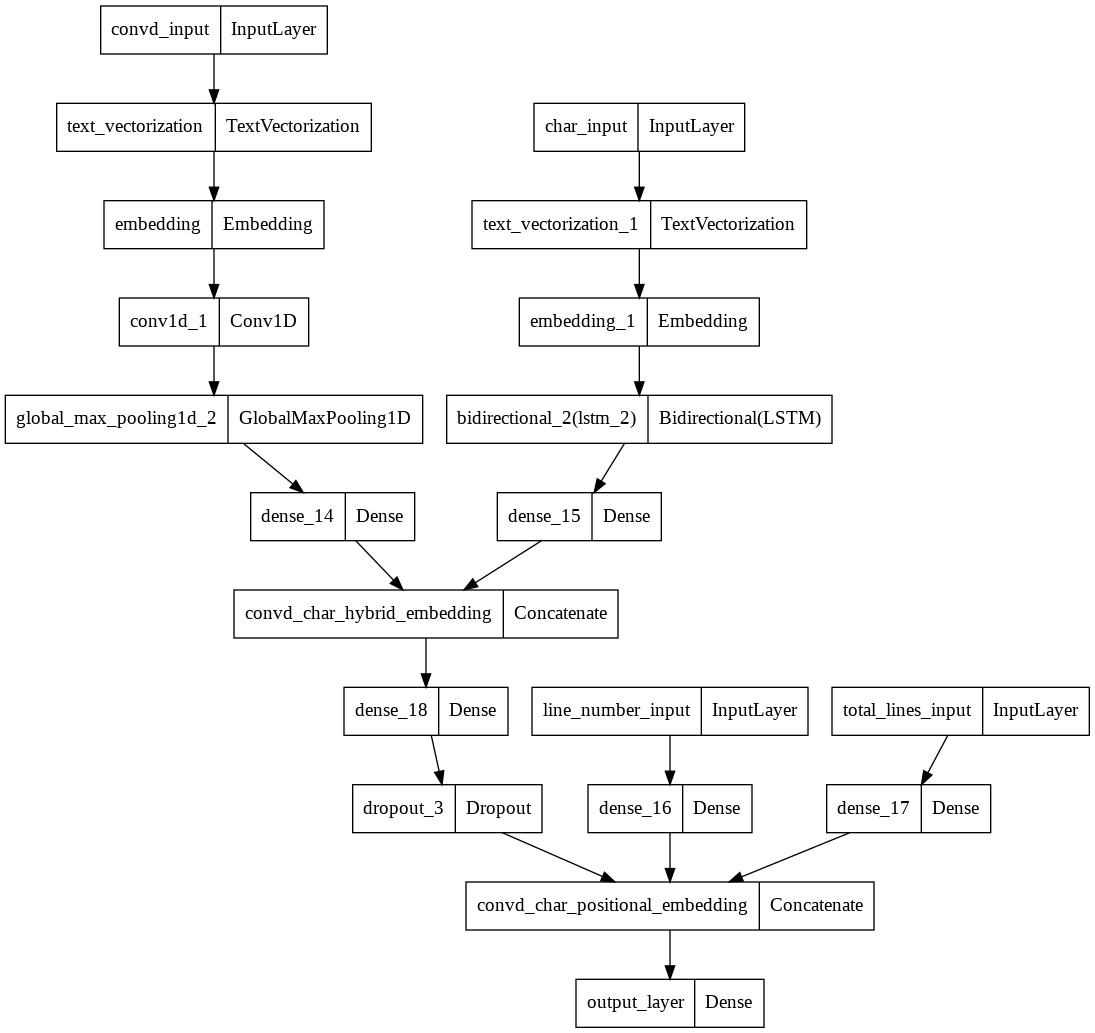

In [98]:
plot_model(model_6)

In [99]:
# Compile convd, char, positional embedding model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [100]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_convd_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_line_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_convd_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_convd_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_convd_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_line_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_convd_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_convd_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_convd_dataset, val_pos_char_convd_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [101]:
# Fit the token, char and positional embedding model
history_model_6 = model_6.fit(train_pos_char_convd_dataset,
                              steps_per_epoch=int(0.25 * len(train_pos_char_convd_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_convd_dataset,
                              validation_steps=int(0.25 * len(val_pos_char_convd_dataset)))

Epoch 1/3
1406/1406 [==============================] - 171s 118ms/step - loss: 0.9283 - accuracy: 0.8406 - val_loss: 0.8931 - val_accuracy: 0.8570
Epoch 2/3
1406/1406 [==============================] - 165s 117ms/step - loss: 0.8637 - accuracy: 0.8840 - val_loss: 0.8823 - val_accuracy: 0.8616
Epoch 3/3
1406/1406 [==============================] - 165s 117ms/step - loss: 0.8918 - accuracy: 0.8613 - val_loss: 0.8766 - val_accuracy: 0.8686


In [102]:
# Evaluate on the whole validation dataset
model_6.evaluate(val_pos_char_convd_dataset)
model_6

945/945 [==============================] - 40s 42ms/step - loss: 0.8752 - accuracy: 0.8707


In [103]:
# Make predictions with token-char-positional hybrid model
model_6_pred_probs = model_6.predict(val_pos_char_convd_dataset, verbose=1)
model_6_pred_probs

945/945 [==============================] - 36s 38ms/step


array([[0.5824517 , 0.05998459, 0.0241634 , 0.2998936 , 0.03350672],
       [0.6328928 , 0.12778455, 0.0583985 , 0.16032712, 0.02059699],
       [0.37794632, 0.06931844, 0.09492153, 0.4147955 , 0.04301817],
       ...,
       [0.04023844, 0.06256936, 0.0329669 , 0.03722604, 0.82699925],
       [0.04844132, 0.77505106, 0.02750227, 0.02358415, 0.12542108],
       [0.05939996, 0.8869443 , 0.01096577, 0.02148086, 0.02120925]],
      dtype=float32)

In [104]:
 #Turn prediction probabilities into prediction classes
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [105]:
# Calculate results of token-char-positional hybrid model
model_6_results = calculate_results(y_true=valid_label_encoder,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 87.0713623725672,
 'f1': 0.8673290676910687,
 'precision': 0.8755804578193562,
 'recall': 0.870713623725672}

###Compare model results

In [106]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results,
                                  "tribrid_pos_char_convd_embed": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,81.858202,0.818191,0.818582,0.815124
pretrained_token_embed,74.721965,0.741390,0.747220,0.741869
custom_char_embed_conv1d,53.369522,0.542651,0.533695,0.518676
hybrid_char_token_embed,70.359460,0.696359,0.703595,0.692993
tribrid_pos_char_token_embed,82.596319,0.829425,0.825963,0.821599
tribrid_pos_char_convd_embed,87.071362,0.875580,0.870714,0.867329


In [107]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results["accuracy"]

baseline                        0.721832
custom_token_embed_conv1d       0.818582
pretrained_token_embed          0.747220
custom_char_embed_conv1d        0.533695
hybrid_char_token_embed         0.703595
tribrid_pos_char_token_embed    0.825963
tribrid_pos_char_convd_embed    0.870714
Name: accuracy, dtype: float64

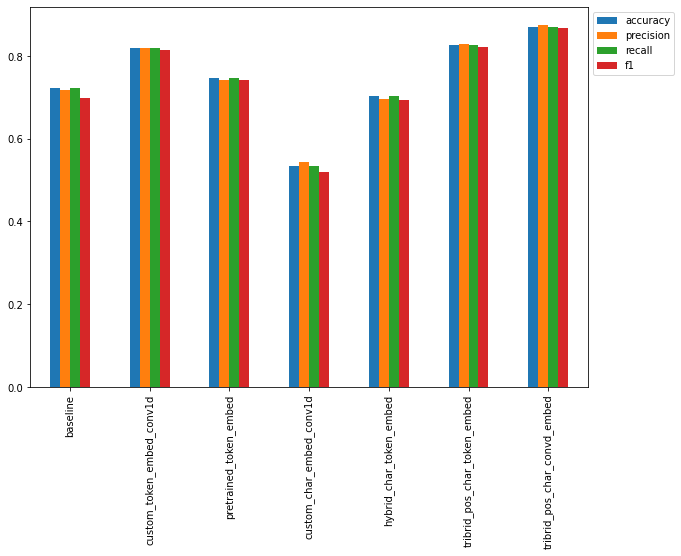

In [108]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0),);

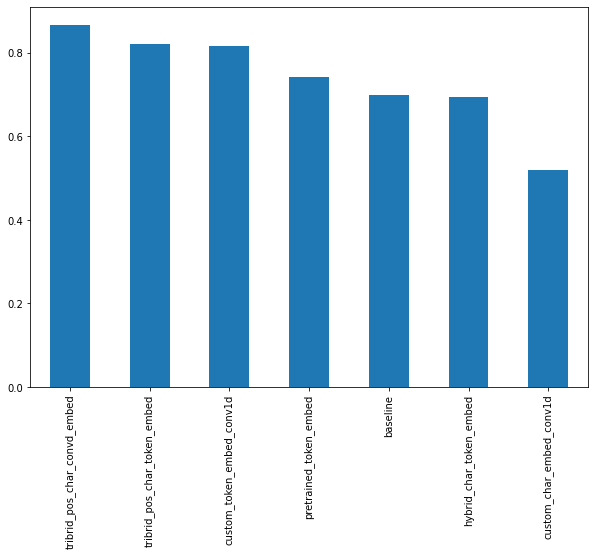

In [109]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Save and load best performing model

In [113]:
# Save best performing model to SavedModel format (default)
tf.keras.models.save_model(model_6,"skimlit_model.HDF5") # model will be saved to path specified by string

INFO:tensorflow:Assets written to: skimlit_model.HDF5/assets


INFO:tensorflow:Assets written to: skimlit_model.HDF5/assets


In [114]:
# Load downloaded model from Google Storage
#loaded_model = tf.keras.models.load_model(model_path)
loaded_model = tf.keras.models.load_model('/content/skimlit_model.HDF5')

Make predictions and evalaute them against the truth labels

In [205]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_convd_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 37s 39ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 2, 4, 2, 4, 1])>

In [118]:
# Evaluate loaded model's predictions
model_6.evaluate(val_pos_char_convd_dataset)
model_6

945/945 [==============================] - 41s 43ms/step - loss: 0.8752 - accuracy: 0.8707


### Let's perform the test on test data

In [119]:
# Create test dataset batch and prefetched
test_pos_char_convd_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_line_one_hot,
                                                               test_sentences,
                                                               test_chars))

test_pos_char_convd_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_convd_dataset = tf.data.Dataset.zip((test_pos_char_convd_data, test_pos_char_convd_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_convd_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [120]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_convd_dataset,verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 36s 38ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [190]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_label_encoder,y_pred=test_preds)
loaded_model_test_results

{'accuracy': 86.4808362369338,
 'f1': 0.860748536138538,
 'precision': 0.8686480239092144,
 'recall': 0.864808362369338}

In [201]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [202]:
%%time
# Get list of class names of test predictions
test_pred_classes = [class_names[pred]for pred in test_preds]

CPU times: user 23.4 s, sys: 1.29 s, total: 24.7 s
Wall time: 26.9 s


In [203]:
test_pred_classes[:10]

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

In [197]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["Target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,Target,Text,Line_number,Total_lines,pred_prob,prediction,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,0.581875,OBJECTIVE,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,0.709784,METHODS,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,0.866547,METHODS,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,0.853069,METHODS,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,0.649711,RESULTS,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,0.826604,RESULTS,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,0.876368,RESULTS,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,0.687945,CONCLUSIONS,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,0.842164,CONCLUSIONS,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,0.654231,BACKGROUND,True


In [218]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
print(f'total numner of worng prediction:{ len(top_100_wrong)}')

total numner of worng prediction:100


In [221]:
top_100_wrong[:10]

,Target,Text,Line_number,Total_lines,pred_prob,prediction,correct
12135,RESULTS,patients who were enrolled as cases were ontar...,3,16,0.935299,METHODS,False
18190,RESULTS,providers were randomized into @ groups : se c...,4,17,0.921880,METHODS,False
3574,RESULTS,the intervention was delivered to children ran...,4,16,0.921404,METHODS,False
6026,RESULTS,patients with higher risk mds or with aml aged...,3,15,0.921323,METHODS,False
5394,RESULTS,"a randomized , double-blind , crossover study ...",3,12,0.916492,METHODS,False
21382,OBJECTIVE,"design , settings , participants , and interve...",3,13,0.916179,METHODS,False
19048,RESULTS,a total of eighty migraineurs without aura wer...,3,10,0.913023,METHODS,False
4699,RESULTS,the primary efficacy end point was primary pat...,3,12,0.912447,METHODS,False
20346,RESULTS,outcomes were examined using kaplan-meier and ...,3,8,0.911173,METHODS,False
10137,RESULTS,this two-group online individually randomised ...,4,14,0.911026,METHODS,False


In [210]:
# Investigate which one are wrong predictions:
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: RESULTS, Pred: 0.9352990388870239, Prob: METHODS, Line number: 3, Total lines: 16

Text:
patients who were enrolled as cases were ontarians aged @ years or older hospitalized with hypomagnesemia .

-----

Target: RESULTS, Pred: 0.9218803644180298, Prob: METHODS, Line number: 4, Total lines: 17

Text:
providers were randomized into @ groups : se clinicians were enrolled in the game , whereas control clinicians received identical educational content in an online posting .

-----

Target: RESULTS, Pred: 0.9214037656784058, Prob: METHODS, Line number: 4, Total lines: 16

Text:
the intervention was delivered to children randomly selected from classes @ and @ who were followed up for @ months .

-----

Target: RESULTS, Pred: 0.9213234186172485, Prob: METHODS, Line number: 3, Total lines: 15

Text:
patients with higher risk mds or with aml aged @ years were eligible .

-----

Target: RESULTS, Pred: 0.9164919853210449, Prob: METHODS, Line number: 3, Total lines: 12

Text:
a randomized 